# EXPLAINABILITY METHODS

In [ ]:
import os
import re
import copy
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import PIL
import io
import cv2
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader, sampler, random_split
from scipy.stats import chi2_contingency

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import wandb
from tqdm import tqdm
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')


# Explainability libraries
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import Occlusion
from captum.attr import GuidedGradCam
from captum.attr import Lime

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#wandb.init(project="resnet152 20 epoch TRY")

Using device: cuda


: 

## CLASSES AND FUNCTIONS

Obtain image, label and name of the image when I enter a dataframe:

In [ ]:
class CustomDataset(Dataset):
    """
    A custom Dataset class that loads images and their corresponding labels from a DataFrame.
    Each row in the DataFrame should contain the image file path and its label.
    Applies image transformations using torchvision transforms.
    """
    def __init__(self, dataframe, transform=None):
        """
        Initializes the dataset.
        Input:
            dataframe: DataFrame containing image paths and labels.
            transform: Optional transformations to apply to each image.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Retrieves a single sample from the dataset.
        Input:
            idx: Index of the sample to retrieve.

        Output:
                image_tensor: Transformed image.
                label: Ground truth label (0 or 1).
                filename: Base name of the image file.
        """
        img_path = self.dataframe.iloc[idx, 0]  # Get image file path
        image = Image.open(img_path).convert('RGB')  # Open and convert to RGB
        label = self.dataframe.iloc[idx, 1]  # Get label (0 or 1)
        
        if self.transform:
            image = self.transform(image)  # Apply data transformations
        
        return image, label, os.path.basename(img_path)  # Return image, label, filename

: 

Transformations of the images depending on the sets: train, test or val

In [ ]:
transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize(256),  # Redimensiona la part curta a 256
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'val_transforms' : transforms.Compose([
    transforms.Resize(256),          # Redimensiona la part curta a 256
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize(256),          # Redimensiona la part curta a 256
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])}


: 

Model Resnet50 300 epochs early stopping (19 epochs):

In [ ]:
class Model(nn.Module):
    """
    A custom neural network model based on a pretrained ResNet50 for binary classification (Pneumonia detection).

    - Replaces the ResNet50 classifier with a custom fully connected head.
    - Freezes early layers to focus training on higher-level features and make fine tunning.
    - Includes methods for forward propagation and model training with early stopping and learning rate scheduling.
    - Training metrics and performance are logged using Weights & Biases (wandb).
    """
    def __init__(self):
        """
        Initializes the model by:
        - Loading a pretrained ResNet50.
        - Replacing the default classifier with a custom sequential classifier suited for binary classification.
        - Freezing all layers except 'layer4' and the classifier to fine-tune only the last layers.
        """
        # Load pretrained ResNet50
        super(Model, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        # Replace the default classifier with a custom one
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),  # Reduces characteristics to 512
            nn.ReLU(),  # Activates the neurons in a non linear way
            nn.Dropout(0.4),  # Reduces overfitting by eliminating connections in each forward pass
            nn.Linear(512, 2)  # Reduces to 2 classes (Pneumonia or No Pneumonia)
            #nn.LogSoftmax(dim=1)  # Converts the outputs into logarithmic probabilities
        )

        # Freeze early layers except 'layer4' and the classifier
        for name, param in self.model.named_parameters():
            if "layer4" not in name and "fc" not in name:
                param.requires_grad = False

        # Replace the original fully connected layer
        self.model.fc = self.classifier

    def forward(self, x):
        """
        Defines the forward pass of the model.
        Input: tensor (image batch).
        Output: logits for classification.
        """
        return self.model(x)   
    
    def fit(self, dataloaders, num_epochs):
        """
        Trains the model using a given number of epochs with early stopping and learning rate scheduling.

        - Uses separate learning rates for the last ResNet block (layer 4) and the classifier.
        - Applies gradient clipping to stabilize training.
        - Logs training and validation metrics (loss and accuracy) to wandb.
        - Saves the best model weights based on validation accuracy.

        Input: 
            dataloaders: Containing 'train' and 'val' DataLoaders.
            num_epochs: Number of epochs to train the model.

        Returns: The trained model with the best validation performance.
        """
        train_on_gpu = torch.cuda.is_available()
        # Optimizer with separate learning rates for the final layers
        optimizer = optim.Adam(
            [
                {"params": self.model.layer4.parameters(), "lr": 1e-4},  # Smaller learning rate
                {"params": self.model.fc.parameters(), "lr": 1e-3}       # Bigger learning rate
            ]
        )
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)  # Based in val_acc
        # Loss function
        criterion = nn.CrossEntropyLoss()  # Better than NLLLoss
        
        since = time.time()  
        patience = 10
        counter = 0      
        
        # Save the best model weights
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        if train_on_gpu:
            self.model = self.model.to(device)
        for epoch in range(1, num_epochs + 1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)            
            
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()                
                    
                running_loss = 0.0
                running_corrects = 0.0                
                
                for inputs, labels, _ in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                    optimizer.zero_grad()                    
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)                        
                        
                        if phase == 'train':
                            loss.backward()
                            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                            optimizer.step() 
                            
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)                
                    
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)                
                
                # We send the metrics to Weights & Biases
                if phase == 'train':
                    wandb.log({"Train Loss": epoch_loss, "Train Accuracy": epoch_acc, "epoch": epoch})
                else:
                    wandb.log({"Validation Loss": epoch_loss, "Validation Accuracy": epoch_acc, "epoch": epoch})                
                    
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))               
                
                # Early stopping based on validation accuracy
                if phase == 'val':
                    scheduler.step(epoch_loss)
                
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(self.model.state_dict())        
                        counter = 0
                    else:
                        counter += 1
                    
                    if counter >= patience:
                        print("🛑 Early stopping activat!")
                        self.model.load_state_dict(best_model_wts)  # Get the best model
                        return self.model
                    
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print("best val acc: {:.4f}".format(best_acc))        
        
        self.model.load_state_dict(best_model_wts)
        return self.model

: 

Classes names:

In [ ]:
noms_classes= ['no_pneumo', 'pneumo']

: 

#### EXPLAINABILITY

In [ ]:
def dilate_attributions(attributions_list, kernel_size=9, iterations=1):
    """
    Dilates the attribution maps according obtained from an explainability method.
    Input:
        attributions_list: list with the attribution maps obtained from an explainability method.
        kernel_size: the size of the square kernel used for dilating the attribution maps.
        iterations: number of iterations for the dilation.
    Output: List of dilated attributions
    """
    attributions_list_dilated = []
    for i in range(len(attributions_list)):
        attributions_np = attributions_list[i]
        attributions_np = attributions_np.transpose(1,2,0)
        attributions_dilated = cv2.dilate(attributions_np, np.ones((kernel_size, kernel_size), np.uint8), iterations=1)
        attributions_dilated = attributions_dilated.transpose(2,0,1)
        attributions_list_dilated.append(attributions_dilated)
    return attributions_list_dilated

: 

In [ ]:
def show_attributions(attributions_list, original_imgs, cmap='coolwarm', alpha_map=0.8, alpha_img=0.4, title=None):
    """
    Plots 10 images of the attribution maps overlayed on the original images.
    Input:
        attributions_list: list with the attribution maps obtained from an explainability method.
        original_imgs: list containing the arrays of the original images
        labels: array with the label for each image.
        predictions: array with the prediction for reach image.
        cmap: color map to use. Default 'coolwarm'.
        alpha_map: alpha value for the attribution maps.
        alpha_img: alpha value for the original images.
        title: title for the figure. Default None.
    """
    attr = attributions_list[0]
    if attr.shape[0] == 3:  # channel-first
        attr = np.transpose(attr, (1, 2, 0))
    
    if original_imgs.shape[0] == 3:  # also transpose if needed
        original_imgs = np.transpose(original_imgs, (1, 2, 0))
        
    if attr.ndim == 3 and attr.shape[2] == 3:
        attr = np.mean(attr, axis=2)



    #attributions_channels_merged = np.maximum(attributions_list[i][0], attributions_list[i][1], attributions_list[i][2])
    plt.imshow(attr, cmap=cmap, alpha=alpha_map, interpolation='nearest')
    plt.imshow(original_imgs, cmap='gray', alpha=alpha_img)
    plt.axis('off')
    plt.show()

: 

In [ ]:
def adaptar_attributions_i_normalitzar (attributions_list):
    """
    Adapts and normalizes attribution maps for visualization or further processing.

    Input:
        attributions_list: List containing attribution tensors, typically from Captum. The first element is expected to be a tensor of shape (3, H, W) or (H, W).

    Returns:
        numpy.ndarray: Normalized single-channel attribution map scaled between 0 and 1, converted to a 2D array (H, W).
    """
    # Extracts the first attribution tensor and squeezes it to remove any extra dimensions.
    attr = attributions_list[0].squeeze()  # shape: (3, H, W) o (H, W)

    # If the attribution has 3 channels (RGB), converts it to grayscale by averaging across channels.
    if attr.ndim == 3:
        attr = np.mean(attr, axis=0)  # form (H, W)

    # Normalizes the values to the [0, 1] range to standardize intensity.
    attr = (attr - np.min(attr)) / (np.max(attr) - np.min(attr) + 1e-8)
    
    return attr

: 

Càlcul IOU:

In [ ]:
def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) between two bounding boxes.
    Input:
        box1: [x, y, w, h]
        box2: [x, y, w, h]
        
    Output: IoU value, intersection coordinates
    """
    # Intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])
    
    # Height and width of the intersection
    inter_width = max(0, x2 - x1)
    inter_height = max(0, y2 - y1)
    inter_area = inter_width * inter_height

    # Area of both bounding boxes
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]

    # Union
    union_area = box1_area + box2_area - inter_area

    # IoU
    if union_area == 0:
        return 0
    return inter_area / union_area, (x1, y1, x2, y2)

: 

In [ ]:
def gth_bb_csv(csv_path):
    """
    Reads a CSV file and returns a dictionary of bounding boxes grouped by image name.

    Input:
        csv_path: Path to the CSV file containing bounding box data.

    Output:
        dict: A dictionary where keys are image filenames and values are lists of bounding boxes. Each bounding box is represented as [x, y, width, height] with integer coordinates.
    """
    bounding_boxes = {}
    with open(csv_path, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # Skips the CSV header row.
        for row in csv_reader:
            if (len(row)==6):
                image_name, x, y, w, h, _ = row
            else:
                image_name, x, y, w, h = row
            # Only includes bounding boxes where all coordinates are present.
            if x and y and w and h:
                x, y, w, h = int(float(x)), int(float(y)), int(float(w)), int(float(h))
                if image_name not in bounding_boxes:
                    bounding_boxes[image_name] = []
                bounding_boxes[image_name].append([x, y, w, h])
                
    return bounding_boxes

: 

In [ ]:
def normalitza_bb(bb):
    """
    Normalizes bounding box coordinates from 255-scale to 1024-scale.
    
    Input:
        bb: Bounding box [x, y, w, h] list
        
    Output: List of normalized bounding box
    """
    return [int(coord * float(1024/255)) for coord in bb]

: 

In [ ]:
def draw_intersections(image_path, ground_truth_boxes, predicted_boxes, csv_iou):
    """
    Draws intersections between predicted and ground truth bounding boxes on an image.
    
    Input:
        image_path: Path to the image file.
        ground_truth_boxes: List of ground truth boxes [[x, y, w, h], ...]
        predicted_boxes: List of predicted boxes [[x, y, w, h], ...]
        csv_iou: Path to the output CSV for IoU logging.
        
    Output: Image with drawn bounding boxes and intersections of None.
    """
    # Comprova si el fitxer existeix
    if not os.path.exists(image_path):
        print(f"Error: La imatge {image_path} no existeix.")
        return None

    # Carrega la imatge
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: No es pot llegir la imatge {image_path}.")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print('IOU>0:')
    # Itera sobre les boxes de veritat i les prediccions
    for gt_box in ground_truth_boxes:
        for pred_box in predicted_boxes:
            pred_box= normalitza_bb(pred_box)
            iou, intersection_coords = calculate_iou(gt_box, pred_box)
            
            with open(csv_iou, mode='a', newline='') as csv_file:
                csv_writer = csv.writer(csv_file)
                #csv_writer.writerow([image_name,iou])
            
            cv2.rectangle(image, (pred_box[0], pred_box[1]), (pred_box[0]+pred_box[2], pred_box[1]+pred_box[3]), (255,0,0), 5) 
            
            # Dibuixa la intersecció en blau si hi ha una intersecció
            if iou > 0:
                print(iou)
                # Assegura't que les coordenades siguin enters
                x1, y1, x2, y2 = map(int, intersection_coords)
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), -1)
        
        cv2.rectangle(image, (gt_box[0], gt_box[1]), (gt_box[0]+gt_box[2], gt_box[1]+gt_box[3]), (0,255,0), 5)                

    return image

: 

Grad Cam hand made:

In [ ]:
# Hooks to capture features and gradients
features = None
gradients = None

def forward_hook(module, input, output):
    """
    Forward hook function to capture and store the output (features) of a specific layer during the forward pass.

    Input:
        module: The layer/module to which the hook is attached.
        input: Input to the layer.
        output: Output from the layer.
    """
    global features
    features = output

def backward_hook(module, grad_in, grad_out):
    """
    Backward hook function to capture and store the gradients flowing out of a specific layer during backpropagation.

    Input:
        module: The layer/module to which the hook is attached.
        grad_in: Incoming gradients to the layer.
        grad_out: Outgoing gradients from the layer.
    """
    global gradients
    gradients = grad_out[0]


: 

In [ ]:
# Image preprocessing function
def preprocess_image(image_path):
    """
    Preprocesses an input image for model inference.
    Input:
        image_path: Path to the input image file.

    Output: Preprocessed image tensor with a batch dimension, moved to the target device.
    """
    preprocess = transformers['test_transforms']
    image = Image.open(image_path).convert('RGB')  # Open image and convert to RGB
    image = preprocess(image)  # Apply transformations, output shape: (C, H, W)
    return image.unsqueeze(0).to(device)  # Add batch dimension and move to device (CPU/GPU)

: 

In [ ]:
## Per mirar si la sortida del Grad cam, la probabilitat, coincideix amb el resultat del test, que hauria de ser igual ##
def search_filename_in_csv(csv_path, target_filename):
    """
    Searches for a specific filename in a CSV file and returns its associated max value.
    Input:
        csv_path: Path to the CSV file.
        target_filename: Filename to search for.

    Output: The max value associated with the filename if found, else None.
    """
    with open(csv_path, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file)
        header = next(csv_reader)  # Read the header
        for row in csv_reader:
            filename, max_val = row  # Unpack each row
            if filename == target_filename:
                return float(max_val)  # Return max_val as float if filename matches
    return None  # Return None if filename not found

: 

In [ ]:
# Function to compute the CAM
def compute_cam(input_image, csv_path, f, model_ft):

    """
    Computes the Class Activation Map (CAM) for a given input image using a model.

    Input:
        input_image: Preprocessed image tensor with batch dimension.
        csv_path: Path to the CSV file for looking up ground truth predictions.
        f: Filename corresponding to the input image.
        model_ft: The trained model used for prediction and gradient extraction.

    Output: Normalized CAM heatmap resized to (224, 224).
    """

    # Forward pass: get model output predictions
    output = model_ft(input_image)
    max_val, class_idx = output.max(1)  # Get highest score and corresponding class index

    # Compute probability by applying exponential (softmax)
    probability = torch.exp(max_val).item()
    
    print(f"Predicted class index: {noms_classes[class_idx]}, Probability: {probability}")
    print(f"Ground truth prediction from CSV: {search_filename_in_csv(csv_path, f)}")
    
    # Backward pass: compute gradients for the predicted class
    model_ft.zero_grad()
    output[0, class_idx].backward(retain_graph=True)

    if gradients is None:
        raise RuntimeError("Gradients are not being captured. Check hooks and model layers.")
    
    # Global average pooling of gradients (weights)
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
    # Weighted sum of features with gradients weights to get CAM
    cam = torch.sum(weights * features, dim=1, keepdim=True)

    # Apply ReLU to CAM and normalize
    cam = F.relu(cam).squeeze().cpu().detach().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = cam - cam.min()
    cam = cam / cam.max()

    return cam

: 

In [ ]:
# Function to overlay the CAM on the original image
def overlay_cam_on_image(image_path, cam, alpha=0.5):
    """
    Overlays the Class Activation Map (CAM) heatmap on the original image.

    Args:
        image_path: Path to the original image file.
        cam: Normalized CAM heatmap with values between 0 and 1.
        alpha: Transparency factor for the heatmap overlay. Defaults to 0.5.

    Returns: Image with CAM heatmap overlay, RGB format, size (224, 224).
    """
    # Load original image and convert color space from BGR to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))  # Resize to match CAM size

    # Convert CAM from [0,1] float to 8-bit grayscale [0,255]
    cam = np.uint8(255 * cam)

    # Apply a heatmap color map (JET) to the CAM
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistency

    # Combine original image and heatmap using weighted sum
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    return overlay


: 

In [ ]:
## Per obtenir els bounding boxes, hem de binaritzar el cam ##
def binaritzar_cam(cam, threshold):
    """
    Binarizes a Class Activation Map (CAM) based on a given threshold.

    Input:
        cam: Normalized CAM with values between 0 and 1.
        threshold: Threshold value between 0 and 1 for binarization.

    Returns: Binary CAM mask with values 0 or 255 (uint8).
    """
    # Scale CAM to 8-bit grayscale [0, 255]
    cam_uint8 = np.uint8(255 * cam)

    # Apply binary thresholding: pixels above threshold*255 become 255, others 0
    _, binary_cam = cv2.threshold(cam_uint8, threshold * 255, 255, cv2.THRESH_BINARY)

    return binary_cam


: 

In [ ]:
## Guardar els resultats en un csv ##
def save_bounding_boxes_to_csv(csv_path, image_name, bounding_boxes):
    """
    Appends bounding box coordinates for a given image to a CSV file.

    Input:
        csv_path: Path to the CSV file.
        image_name: Name of the image file.
        bounding_boxes: List of bounding boxes, each as (x, y, w, h).
    """
    with open(csv_path, mode='a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        # Write a row for each bounding box
        for (x, y, w, h) in bounding_boxes:
            csv_writer.writerow([image_name, x, y, w, h])


: 

In [ ]:
def get_bounding_boxes(binari_cam):
    """
    Detects contours in a binary CAM mask and returns bounding boxes.

    Input:
        binari_cam: Binary image (mask) where contours are detected.

    Output: List of bounding boxes, each represented as (x, y, w, h).
    """
    # Detect contours in the binary mask
    contorns, _ = cv2.findContours(binari_cam, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Generate bounding boxes from contours
    bounding_boxes = [cv2.boundingRect(cnt) for cnt in contorns]
    return bounding_boxes


: 

In [ ]:
## Dibuixar rectangles ##
def dibuixar_bounding_boxes(imatge, bounding_boxes):
    """
    Draws rectangles of the bounding boxes on top of the image.

    Input:
        imatge: Original image where we will draw the bounding boxes.
        bounding_boxes: List of bounding boxes (x, y, w, h).

    Output: Image with the drawn bounding boxes.
    """
    imatge_bounding_boxes = imatge.copy()
    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(imatge_bounding_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue rectangle
    return imatge_bounding_boxes


: 

In [ ]:
## Dibuixar bounding boxes sobre la imatge ##
def grad_cam_and_bounding_boxes(image, cam, threshold):
    """
    Applies a threshold to the Grad-CAM to extract bounding boxes and draws them on the image.

    Input:
        image: Original image.
        cam: Normalized Grad-CAM heatmap.
        threshold: Threshold value for binarizing the CAM (between 0 and 1).

    Output:
        image_with_bb: Image with bounding boxes drawn.
        bounding_boxes: List of bounding boxes in (x, y, w, h) format.
    """
    # Convert Grad-CAM to binary image using the threshold
    binary_cam = binaritzar_cam(cam, threshold)
    
    # Get bounding boxes from the binary CAM
    bounding_boxes = get_bounding_boxes(binary_cam)
    
    # Draw bounding boxes on the original image
    image_with_bb = dibuixar_bounding_boxes(image, bounding_boxes)
    
    return image_with_bb, bounding_boxes



: 

In [ ]:
def draw_predicted_and_ground_truth_bboxes(image, cam_attr, ground_truth_csv, image_path, image_name, csv_iou, csv_bb):
    """
    Draws predicted bounding boxes from Grad-CAM and ground truth bounding boxes on the image.
    Saves predicted bounding boxes to a CSV file and draws intersections between predicted and ground truth boxes.

    Input:
        image: The original image.
        cam_attr: Grad-CAM attribution map.
        ground_truth_csv: Path to the CSV file with ground truth bounding boxes.
        image_path: Path to the image file.
        image_name: Image filename (used as key in CSV).
        csv_iou: Path to CSV file for saving IoU information.
        csv_bb: Path to CSV file for saving predicted bounding boxes.
    """
    # Get bounding boxes from Grad-CAM heatmap
    _, bounding_boxes = grad_cam_and_bounding_boxes(image, cam_attr, 0.5)
    
    # Save predicted bounding boxes to CSV
    save_bounding_boxes_to_csv(csv_bb, image_name, bounding_boxes)

    # Load ground truth bounding boxes from CSV
    ground_truth_boxes = gth_bb_csv(ground_truth_csv)

    # Draw intersections between predicted and ground truth bounding boxes
    image_with_intersections = draw_intersections(image_path, ground_truth_boxes[image_name], bounding_boxes, csv_iou, image_name)
    
    # Uncomment below to display the image with intersections
    # if image_with_intersections is not None:
    #     plt.imshow(image_with_intersections)
    #     plt.axis('off')
    #     plt.title(f"Intersections for {image_name}")
    #     plt.show()


: 

Occlusion handmade:

In [ ]:
def occlusion_sensitivity(model, image, label_idx, patch_size=7, stride=7):
    """
    Computes an occlusion sensitivity heatmap for a given image and model.
    It systematically occludes patches of the image and measures the drop in the predicted
    probability for the target class, indicating which regions are most important for the prediction.

    Args:
        model: The trained model.
        image: Input image tensor of shape (1, C, H, W).
        label_idx: Index of the target class.
        patch_size: Size of the occlusion patch. Defaults to 7.
        stride: Stride for sliding the occlusion patch. Defaults to 7.

    Returns: Normalized heatmap indicating sensitivity to occlusion (shape H x W).
    """
    _, _, H, W = image.shape
    heatmap = np.zeros((H, W))

    with torch.no_grad():
        output = model(image)
        max_val, class_idx = output.max(1)

        # Get predicted probability for the target class
        probability = torch.exp(max_val).item()

        class_names = ['no_pneumo', 'pneumo']
        print(f"Predicted class index: {class_names[label_idx]}, probability: {probability:.4f}")

    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            occluded = image.clone()
            occluded[:, :, y:y+patch_size, x:x+patch_size] = 0.0  # Zero out the patch

            with torch.no_grad():
                occluded = occluded.to(device)
                output2 = model(occluded)
                probs = torch.exp(output2)
                score = probs[0, label_idx].item()

            drop = probability - score
            heatmap[y:y+patch_size, x:x+patch_size] += drop

    # Normalize heatmap to [0,1]
    heatmap = np.maximum(heatmap, 0)
    print(f"Max heatmap: {heatmap.max()}")
    heatmap /= heatmap.max()
    return heatmap


: 

Obtain explainability via Captum:

In [ ]:
def explicabilitat(method, image_tensor, image, ground_truth_csv, img_path, img_name, method_name, csv_iou, csv_bb):
    """
    Generates and processes attributions for an input image using the specified explainability method.
    It calculates attributions, dilates them for better visibility, normalizes, and then draws predicted
    and ground truth bounding boxes, saving relevant info to CSVs.

    Input:
        method: Explainability method (e.g., Integrated Gradients) with an attribute() function.
        image_tensor: Input tensor representing the image.
        image: Original image (e.g., as a NumPy array or PIL image).
        ground_truth_csv: Path to CSV containing ground truth bounding boxes.
        img_path: Path to the image file.
        img_name: Name of the image.
        method_name: String name of the explainability method.
        csv_iou: Path to CSV file for Intersection-over-Union (IoU) logging.
        csv_bb: Path to CSV file for bounding box logging.
    """

    attributions_list = []

    # Compute attributions for the target class (hardcoded here as target=1)
    attributions = method.attribute(image_tensor, target=1)
    attributions = attributions.squeeze(0).cpu().detach().numpy()
    attributions_list.append(attributions)

    # Dilate attributions to make them more visible
    attributions_list_dilated = dilate_attributions(attributions_list)

    # Optional: show the original and dilated attributions (commented out)
    # show_attributions(attributions_list, image, cmap='coolwarm', alpha_map=0.9, alpha_img=0.2, title=method_name)
    # show_attributions(attributions_list_dilated, image, cmap='coolwarm', alpha_map=0.9, alpha_img=0.2, title=method_name + 'Dilated')

    # Normalize the dilated attributions for further processing
    attr = adaptar_attributions_i_normalitzar(attributions_list_dilated)

    # Draw predicted bounding boxes and ground truth boxes on the image, logging results
    draw_predicted_and_ground_truth_bboxes(image, attr, ground_truth_csv, img_path, img_name, csv_iou, csv_bb)


: 

## MAIN CODE

In [ ]:
########### OBTAIN THE USEFUL DATA OF THE DF ##############
## Directories ##
root_path = '/home/nuria/rsna-pneumonia-challenge/dataset_three_class/'
train_pneumo_images = root_path + 'images/train'
val_pneumo_images = root_path + 'images/val'
image_data = pd.read_csv(root_path + 'stage_2_train_labels.csv')
gth_0= "./ground_truth/no_pneumo"
gth_1 = "./ground_truth/si_pneumo"
ground_truth_csv ='/home/bertam/CHALLENGE/stage_2_train_labels.csv'

# Directories of the results o the evaluation fo the model
save_path_0= "./pa_arreg/classified_images/no_pneumo"
save_path_1= "./pa_arreg/classified_images/pneumo"
csv_path = "./pa_arreg/AP_nw_nls_cf_10_01.csv"

## Load the weights of the model ##
model = Model()
state_dict = torch.load("./Best_weights/no_fer_Cas_PA_def.pth")
model.load_state_dict(state_dict, strict=False)
model_ft = model.model
model_ft.to(device)

model_ft.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

: 

### EXPLAINABILITY

Ho anirem fent només amb una imatge, de moment

In [ ]:
img_pth = '/home/bertam/CHALLENGE/appa_arreg/correct_class/pneumo/1f4741e6-a0ae-41b2-8b70-bf7e927f1b13.png'
img_nom = '1f4741e6-a0ae-41b2-8b70-bf7e927f1b13'

## Preprocess of the input image ##
image_tensor = preprocess_image(img_pth)
image_tensor = image_tensor.to(device)

## Image we want to show ##
imatge = cv2.imread(img_pth)
imatge = cv2.cvtColor(imatge, cv2.COLOR_BGR2RGB)
imatge = cv2.resize(imatge, (224,224))

'\n0.416124553097974\n0.41867954911433175\n'

: 

In [ ]:
good_classification_pneumo = '/home/bertam/CHALLENGE/appa_arreg/correct_class/pneumo'

pneumo_list = [
    os.path.basename(f) for f in os.listdir(good_classification_pneumo)
    if os.path.isfile(os.path.join(good_classification_pneumo, f)) and (f.endswith('.png') or f.endswith('.jpg'))
]

# We modify the names eliminating the suffix after the "_"
correct_pneumo_list = []
for image_path in pneumo_list:
    # We separate the name before the first '_'
    name, _ = os.path.splitext(image_path)  # Separate the name and the extension
    base_name = name.split('_')[0]  # We keep the part before the '_'
    new_name = f"{base_name}.png"  # We rewrite the name with .png as an extension
    correct_pneumo_list.append(new_name)
    
print(correct_pneumo_list)

['bdfea255-f9dc-4694-b0fe-d699aec5b10e.png', 'a28266ba-94b1-4789-88e7-e7a1c4bc6d0d.png', '47a15caf-d139-4fa3-956d-6f8afa5ac376.png', '3397d218-ad10-49dd-a3e0-9b1ee6d3d91d.png', 'b97dadd7-8a4f-4bdf-898e-c59489b8add0.png', 'b8eef91b-bbe7-443c-9e05-b756108d7344.png', '55d5a0b4-ff06-4c41-8aee-d3d49febd027.png', '5c643f67-e321-4f90-bcd0-58c4517561a9.png', '3c2270fa-2323-48c2-a341-1ea0d84d7cee.png', '9ebc1edb-315f-4f0f-bc9b-dfa933bc67d3.png', '125a6b00-d20c-413e-b5fb-3728fcfce39f.png', 'd6724bee-d28e-4b34-8813-52a86955fa72.png', '711b8e6a-0406-4c61-8c13-3e90fd7ecba1.png', '515ab870-a80e-47f1-bd51-05a6fc02cba0.png', 'a9cfed74-19bf-454f-b3a2-32c455a97cc8.png', '9dbb7a32-14df-40ca-871e-410111c45c05.png', 'c28f7725-70a7-4b55-953a-44d28ecdd4fb.png', '03ae75b6-45a7-4a68-9871-f07b82b17bf6.png', '1563a4ed-d5f5-4e31-8818-c5417109d403.png', 'b402b80c-0be4-4c25-80be-d9ace219c83b.png', 'a1538feb-5647-463b-9876-ca6e5ff00f48.png', 'b41dfb17-3773-485b-8da6-c29a2bbfbe3a.png', 'b77669dd-8554-4531-9903-971974

: 

#### GRAD CAM, HANDMADE

In [ ]:
csv_bb_gr= './pa_arreg/bb_gr.csv'
csv_iou_gr= './pa_arreg/iou_gr.csv'

: 

In [ ]:
with open(csv_bb_gr, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "x", "y", "w", "h"])

with open(csv_iou_gr, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "iou"])

for im in correct_pneumo_list:
    img_pth = '/home/bertam/CHALLENGE/appa_arreg/correct_class/pneumo/'+ im
    img_nom = im.replace('.png','')

    ## Preprocess of the input image ##
    image_tensor = preprocess_image(img_pth)
    image_tensor = image_tensor.to(device)

    ## Image we want to show ##
    imatge = cv2.imread(img_pth)
    imatge = cv2.cvtColor(imatge, cv2.COLOR_BGR2RGB)
    imatge = cv2.resize(imatge, (224,224))

    ## We define the target layer, las fc or convolutional, we choose layer 4 ##
    target_layer = model_ft.layer4
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)


    ## Compute the CAM ##
    cam = compute_cam(image_tensor, csv_path, img_nom, model_ft)


    ## Draw the bounding boxes on top of the image ##
    overlay = overlay_cam_on_image(img_pth, cam)
    imatge_conv_bb_gr , bounding_boxes_gr = grad_cam_and_bounding_boxes(imatge, cam, 0.5)

    # Save the bounding boxes in the CSV file
    save_bounding_boxes_to_csv(csv_bb_gr, img_nom, bounding_boxes_gr)

    #plt.imshow(imatge_conv_bb_gr)
    #plt.axis('off')
    #plt.show()


    ## I show the heatmap and the bounding box from the real lesion ##
    import importlib
    import obtenir_images_lesions_python
    importlib.reload(obtenir_images_lesions_python)
    #obtenir_images_lesions_python.obtenir_bounding_box(img_nom, overlay)

    draw_predicted_and_ground_truth_bboxes(imatge, cam, ground_truth_csv, img_pth, img_nom, csv_iou_gr, csv_bb_gr)

Predicted class index: ('no_pneumo', 0.6099072098731995)
Predicció testing: 0.7439338564872742 
IOU>0:
0.06468517915561964
Predicted class index: ('no_pneumo', 0.8569998741149902)
Predicció testing: 0.8051203489303589 


IOU>0:
Predicted class index: ('no_pneumo', 0.8702614903450012)
Predicció testing: 0.7224294543266296 
IOU>0:
0.17842081359891002
Predicted class index: ('no_pneumo', 0.8250240087509155)
Predicció testing: 0.6716090440750122 
IOU>0:
0.1359886662618903
Predicted class index: ('no_pneumo', 0.9373731017112732)
Predicció testing: 0.5667243599891663 
IOU>0:
0.21955237916118112
Predicted class index: ('no_pneumo', 0.7422411441802979)
Predicció testing: 0.6776309013366699 
IOU>0:
0.18465577834131067
Predicted class index: ('no_pneumo', 0.7285540699958801)
Predicció testing: 0.7316307425498962 
IOU>0:
Predicted class index: ('no_pneumo', 0.7195401787757874)
Predicció testing: 0.551444411277771 
IOU>0:
0.05350813569991652
Predicted class index: ('no_pneumo', 0.9411548376083374)
Predicció testing: 0.6343291401863098 
IOU>0:
0.11174580147288461
Predicted class index: ('pneumo', 0.9062737822532654)
Predicció testing: 0.7849245071411133 
IOU>0:
Predicted class index: ('no_pneumo', 0.945740640163421

: 

#### GUIDED GRAD CAM

In [ ]:
csv_bb_ggr= './pa_arreg/bb_ggr.csv'
csv_iou_ggr= './pa_arreg/iou_ggr.csv'

: 

In [ ]:
with open(csv_bb_ggr, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "x", "y", "w", "h"])

with open(csv_iou_ggr, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "iou"])

gradcam = GuidedGradCam(model_ft, model_ft.layer4)

for im in correct_pneumo_list:
    img_pth = '/home/bertam/CHALLENGE/appa_arreg/correct_class/pneumo/'+ im
    img_nom = im.replace('.png','')

    ## Preprocess the input image ##
    image_tensor = preprocess_image(img_pth)
    image_tensor = image_tensor.to(device)

    ## Showing image ##
    imatge = cv2.imread(img_pth)
    imatge = cv2.cvtColor(imatge, cv2.COLOR_BGR2RGB)
    imatge = cv2.resize(imatge, (224,224))
    explicabilitat(gradcam, image_tensor, imatge, ground_truth_csv, img_pth, img_nom, 'Guided Grad Cam', csv_iou_ggr, csv_bb_ggr)


IOU>0:
IOU>0:
IOU>0:
IOU>0:
IOU>0:
IOU>0:
IOU>0:
IOU>0:
IOU>0:
IOU>0:
IOU>0:
IOU>0:
IOU>0:
0.22159497196191336
IOU>0:
0.03884305357989568
0.015173067804646752
0.15051683262209578
0.041270744428639164
IOU>0:
0.11544011544011544
0.012296881862099254
0.029845178138407015
0.07729468599033816
0.05420666290231508
IOU>0:
IOU>0:
IOU>0:
0.022224992431392802
0.020372909728776735
IOU>0:
IOU>0:
0.010666343444138056
0.029308734930802126
0.004075394803871625
0.016556291390728478
0.013075224995754798
0.006877228731533368
IOU>0:
0.07424593967517401
IOU>0:
0.18655988857938718
IOU>0:
0.01044932079414838
0.017659352142110764
0.008463949843260187
0.08150470219435736
0.02127659574468085
0.08878579427291633
IOU>0:
IOU>0:
0.002055230234720342
0.2637118025434964
IOU>0:
0.0024
0.039
0.004
0.02
0.1452
0.0028873917228103944
IOU>0:
0.017006802721088437
0.06666666666666667
IOU>0:
0.043783595113438045
0.031938729783680286
0.10823545715968541
IOU>0:
IOU>0:
0.010779877561884482
0.03148654665733732
IOU>0:
0.0168225000

'\n0.02019226274870293\n0.006721982984980569\n0.029787234042553193\n'

: 

#### OCCLUSION A MÀ

In [ ]:
csv_bb_occ= './pa_arreg/bb_occ.csv'
csv_iou_occ= './pa_arreg/iou_occ.csv'

: 

In [ ]:
with open(csv_bb_occ, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "x", "y", "w", "h"])

with open(csv_iou_occ, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "iou"])


for im in correct_pneumo_list:
    img_pth = '/home/bertam/CHALLENGE/appa_arreg/correct_class/pneumo/'+ im
    img_nom = im.replace('.png','')

    ## Preprocess the input image ##
    image_tensor = preprocess_image(img_pth)
    image_tensor = image_tensor.to(device)

    ## Showing image ##
    imatge = cv2.imread(img_pth)
    imatge = cv2.cvtColor(imatge, cv2.COLOR_BGR2RGB)
    imatge = cv2.resize(imatge, (224,224))
    heatmap_occ = occlusion_sensitivity(model_ft, image_tensor, label_idx=1)
    heatmap_resized = cv2.resize(heatmap_occ, (imatge.shape[1], imatge.shape[0]))

    print(f"Predicció testing: {search_filename_in_csv(csv_path, img_nom)} ")

    #plt.imshow(imatge)
    #plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    #plt.title("Occlusion Sensitivity")
    #plt.axis('off')
    #plt.show()
    ## Mostar bb + real ##
    draw_predicted_and_ground_truth_bboxes(imatge, heatmap_occ, ground_truth_csv, img_pth, img_nom, csv_iou_occ, csv_bb_occ)

"""
IOU>0:
0.3555852619266438
0.5433125433125433
"""

Predicted class index: pneumo, probability: 0.6099
Max heatmap:0.27873387932777405
Predicció testing: 0.7439338564872742 
IOU>0:
0.05143646196923785
Predicted class index: pneumo, probability: 0.8570
Max heatmap:0.7617723420262337
Predicció testing: 0.8051203489303589 
IOU>0:
0.06688187715679639
Predicted class index: pneumo, probability: 0.8703
Max heatmap:0.7507588490843773
Predicció testing: 0.7224294543266296 
IOU>0:
0.12831461480498044
Predicted class index: pneumo, probability: 0.8250
Max heatmap:0.6855189055204391
Predicció testing: 0.6716090440750122 
IOU>0:
0.04541444516896168
Predicted class index: pneumo, probability: 0.9374
Max heatmap:0.882375568151474
Predicció testing: 0.5667243599891663 
IOU>0:
0.08267992739429919
0.036109829114292114
Predicted class index: pneumo, probability: 0.7422
Max heatmap:0.5245490521192551
Predicció testing: 0.6776309013366699 
IOU>0:
0.06735329453935346
0.03596630046238498
Predicted class index: pneumo, probability: 0.7286
Max heatmap:0.538942

'\nIOU>0:\n0.3555852619266438\n0.5433125433125433\n'

: 

#### OCCLUSION

In [ ]:
csv_bb_occ_auto= './pa_arreg/bb_occ_auto.csv'
csv_iou_occ_auto= './pa_arreg/iou_occ_auto.csv'

: 

In [ ]:
occlusion = Occlusion(model_ft)
attributions_occ_list = []

with open(csv_bb_occ_auto, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "x", "y", "w", "h"])

with open(csv_iou_occ_auto, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "iou"])


for im in correct_pneumo_list:
    img_pth = '/home/bertam/CHALLENGE/appa_arreg/correct_class/pneumo/'+ im
    img_nom = im.replace('.png','')

    ## Preprocess the input image ##
    image_tensor = preprocess_image(img_pth)
    image_tensor = image_tensor.to(device)

    ## Showing image ##
    imatge = cv2.imread(img_pth)
    imatge = cv2.cvtColor(imatge, cv2.COLOR_BGR2RGB)
    imatge = cv2.resize(imatge, (224,224))
    
    heatmap_occ = occlusion_sensitivity(model_ft, image_tensor, label_idx=1)
    heatmap_resized = cv2.resize(heatmap_occ, (imatge.shape[1], imatge.shape[0]))

    baselines = torch.zeros_like(image_tensor).to(device)

    attributions_occ = occlusion.attribute(
        image_tensor,
        strides=(3, 8, 8),
        target=1,
        sliding_window_shapes=(3, 15, 15),
        baselines=baselines
    )
    attributions_occ = attributions_occ.squeeze(0).cpu().detach().numpy()
    attributions_occ_list.append(attributions_occ)


    # SHOWING THE RESULTS
    #show_attributions(attributions_occ_list, imatge, cmap='coolwarm', alpha_map=0.9, alpha_img=0.2, title='Occlusion')

    ## Dibuixar bounding box + real ##
    attr_occ = adaptar_attributions_i_normalitzar(attributions_occ_list)

    draw_predicted_and_ground_truth_bboxes(imatge, attr_occ, ground_truth_csv, img_pth, img_nom, csv_iou_occ_auto, csv_bb_occ_auto)

Predicted class index: pneumo, probability: 0.6099
Max heatmap:0.27873387932777405
IOU>0:
0.05143646196923785
Predicted class index: pneumo, probability: 0.8570
Max heatmap:0.7617723420262337
IOU>0:
0.06688187715679639
Predicted class index: pneumo, probability: 0.8703
Max heatmap:0.7507588490843773
IOU>0:
0.12831461480498044
Predicted class index: pneumo, probability: 0.8250
Max heatmap:0.6855189055204391
IOU>0:
0.04541444516896168
Predicted class index: pneumo, probability: 0.9374
Max heatmap:0.882375568151474
IOU>0:
0.08267992739429919
0.036109829114292114
Predicted class index: pneumo, probability: 0.7422
Max heatmap:0.5245490521192551
IOU>0:
0.06735329453935346
0.03596630046238498
Predicted class index: pneumo, probability: 0.7286
Max heatmap:0.538942739367485
IOU>0:
0.02933304957553876
Predicted class index: pneumo, probability: 0.7195
Max heatmap:0.46540430188179016
IOU>0:
0.014513716266126866
Predicted class index: pneumo, probability: 0.9412
Max heatmap:0.8857514783740044
IOU>

'\nIOU>0:\n0.4201671395294923\n0.6574121503944268\n'

: 

#### SALIENCY

In [ ]:
csv_bb_sali= './pa_arreg/bb_sali.csv'
csv_iou_sali= './pa_arreg/iou_sali.csv'

: 

In [ ]:
with open(csv_bb_sali, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "x", "y", "w", "h"])

with open(csv_iou_sali, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "iou"])

saliency = Saliency(model_ft)

for im in correct_pneumo_list:
    img_pth = '/home/bertam/CHALLENGE/appa_arreg/correct_class/pneumo/'+ im
    img_nom = im.replace('.png','')

    ## Preprocess the input image ##
    image_tensor = preprocess_image(img_pth)
    image_tensor = image_tensor.to(device)

    ## Showing the image ##
    imatge = cv2.imread(img_pth)
    imatge = cv2.cvtColor(imatge, cv2.COLOR_BGR2RGB)
    imatge = cv2.resize(imatge, (224,224))
    heatmap_occ = occlusion_sensitivity(model_ft, image_tensor, label_idx=1)
    heatmap_resized = cv2.resize(heatmap_occ, (imatge.shape[1], imatge.shape[0]))


    explicabilitat(saliency, image_tensor, imatge, ground_truth_csv, img_pth, img_nom, 'Saliency', csv_iou_sali, csv_bb_sali)

Predicted class index: pneumo, probability: 0.6099
Max heatmap:0.27873387932777405
IOU>0:
0.006927906473262611
0.01029697409374927
0.03117557912968175
Predicted class index: pneumo, probability: 0.8570
Max heatmap:0.7617723420262337
IOU>0:
0.02905299739357081
0.18883712376632134
Predicted class index: pneumo, probability: 0.8703
Max heatmap:0.7507588490843773
IOU>0:
0.0007714263673532361
0.1727995062871249
Predicted class index: pneumo, probability: 0.8250
Max heatmap:0.6855189055204391
IOU>0:
0.02789886660854403
Predicted class index: pneumo, probability: 0.9374
Max heatmap:0.882375568151474
IOU>0:
0.028733051988865943
0.009604268563806136
0.08359556710904364
0.06030701754385965
Predicted class index: pneumo, probability: 0.7422
Max heatmap:0.5245490521192551
IOU>0:
0.029392853862404703
0.05760999357031322
0.1165958185130563
0.07443783923494443
0.013354895925713392
Predicted class index: pneumo, probability: 0.7286
Max heatmap:0.538942739367485
IOU>0:
0.05466739781499135
0.01920998919

: 

#### INTEGRATED GRADIENTS

In [ ]:
csv_bb_ig= './pa_arreg/bb_ig.csv'
csv_iou_ig= './pa_arreg/iou_ig.csv'

: 

In [ ]:
integrated_gradients = IntegratedGradients(model_ft)

with open(csv_bb_ig, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "x", "y", "w", "h"])

with open(csv_iou_ig, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Filename", "iou"])


for im in correct_pneumo_list:
    img_pth = '/home/bertam/CHALLENGE/appa_arreg/correct_class/pneumo/'+ im
    img_nom = im.replace('.png','')

    ## Preprocess the input image ##
    image_tensor = preprocess_image(img_pth)
    image_tensor = image_tensor.to(device)

    ## Showing image ##
    imatge = cv2.imread(img_pth)
    imatge = cv2.cvtColor(imatge, cv2.COLOR_BGR2RGB)
    imatge = cv2.resize(imatge, (224,224))

    explicabilitat(integrated_gradients, image_tensor, imatge, ground_truth_csv, img_pth, img_nom, 'Integrated Gradients', csv_iou_ig, csv_bb_ig)

IOU>0:
0.027355964995163212
0.00038488369295903394
0.013179571663920923
0.23862788963460105
IOU>0:
0.23202389156903286
IOU>0:
0.0037028465632955336
0.00030857054694129443
0.00015428527347064721
0.0005398735153478328
0.00030857054694129443
0.003857131836766181
0.470542852698709
0.00030857054694129443
IOU>0:
0.043591979075850044
0.07323452484742807
IOU>0:
0.05160483165598255
0.014592502880099252
0.0014366525994432972
0.02585974678997935
0.0037053374503749448
0.09077362473612319
0.014500395465330872
IOU>0:
0.0005875117043347348
0.02012477359629704
IOU>0:
IOU>0:
0.022609514837494113
IOU>0:
0.009616540449573266
0.007693232359658613
0.05702647657841141
0.20842388118919017
0.4307005471451109
IOU>0:
IOU>0:
0.009609949123798756
0.003393665158371041
0.2407108239095315
IOU>0:
IOU>0:
0.04637038114634856
0.002858840127719611
0.006611818625793606
0.01266977498479627
IOU>0:
0.002034639741600753
0.008548965727807037
0.002440574551925766
0.0030532020456453704
0.002035468030430247
0.006106404091290741
0

: 

### LIME

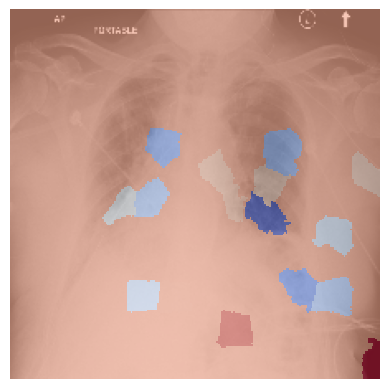

: 

: 

In [ ]:
from skimage.segmentation import slic
import random
###### SEGMENT IMAGES FOR LIME AND SHAP
mask_list = []

image_np = image_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()
mask = slic(image_np, n_segments=150, compactness=10)
mask = mask - 1
mask = torch.tensor(mask)
mask_list.append(mask)
mask_list = [tensor.to(device) for tensor in mask_list]

##### COMPUTE LIME ATTRIBUTIONS
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

lime = Lime(model)
attributions_lime_list = []
mask_tensor = torch.stack(mask_list).to(device)

attributions_lime = lime.attribute(image_tensor,
                                feature_mask=mask_tensor,
                                target=1,
                                n_samples=200)
attributions_lime = attributions_lime.squeeze(0).cpu().detach().numpy()
attributions_lime_list.append(attributions_lime)


#### SHOW LIME ATTRIBUTIONS
show_attributions(attributions_lime_list, imatge, cmap='coolwarm', alpha_map=0.9, alpha_img=0.4, title='Lime')

## PLOT IOU

0.08931092353354164


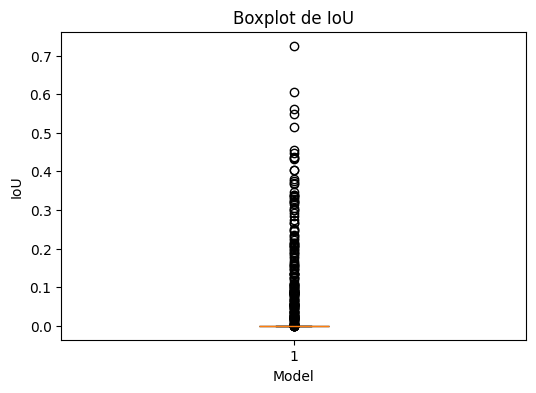

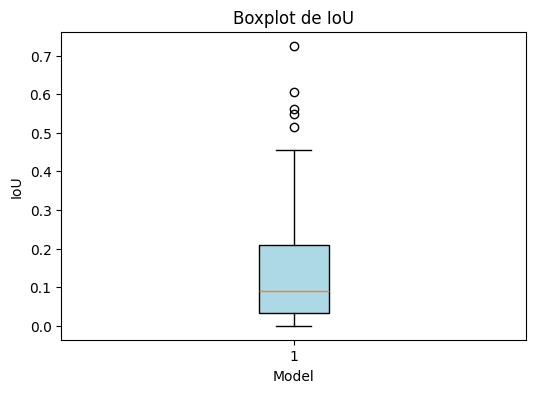

: 

In [ ]:
import io
def crear_boxplot(dades, nom):
    # Boxplot amb Matplotlib
    plt.figure(figsize=(6, 4))
    plt.boxplot(dades, vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
    plt.title("Boxplot de IoU")
    plt.ylabel("IoU")
    plt.xlabel("Model")

#Boxplot iou total
dades_iou= pd.read_csv(csv_iou_occ_auto)
col_iou= dades_iou['iou']
crear_boxplot(col_iou, 'Boxplot IOU')

#Boxplot only iou>0
dades_iou_filtrades = col_iou[col_iou > 0]
crear_boxplot(dades_iou_filtrades, 'Bloxplot IOU>0')

print (dades_iou_filtrades.median())

In [ ]:
def crear_boxplot(dades, nom):
    # Boxplot with Matplotlib
    plt.figure(figsize=(6, 4))
    plt.boxplot(dades, vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
    plt.title("Boxplot de IoU")
    plt.ylabel("IoU")
    plt.xlabel("Model")
    
    # Save the image into a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()  
    buf.seek(0)

    # Convert to array numpy
    im = Image.open(buf)
    im_np = np.array(im)

    # Send the image to wandb
    wandb.log({nom: wandb.Image(im_np)})

#Boxplot iou total
dades_iou= pd.read_csv(csv_iou_gr)
col_iou= dades_iou['iou']
crear_boxplot(col_iou, 'Boxplot IOU')

#Boxplot only iou>0
dades_iou_filtrades = col_iou[col_iou > 0]
crear_boxplot(dades_iou_filtrades, 'Bloxplot IOU>0')

print (dades_iou_filtrades.median())

: 